In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *

from Problem.PerformanceObserver import *

from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.utils import *
from Problem.Sigma_adapted_functions  import *
fraction_type = "2"
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_2"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

sigma_starts = [s[0] for s in sigma_routes]
sigma_ends = [s[-1] for s in sigma_routes]

fraction_max_weight = {"2":500,"3":300,"11":1000}

sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
pickups = sigma_data.where(sigma_data.Type ==1).dropna()
dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
terminals = sigma_data.where(sigma_data.Type == 3).dropna()
sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
meta_data["Customer Amount"] = len(sigma_data)
sigma_lat = sigma_data.Lat.to_numpy()
sigma_long = sigma_data.Long.to_numpy()
sigma_coordinates = np.array([sigma_lat,sigma_long]).T


sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
sigma_distance_matrix = sigma_distance_matrix.to_numpy()
sigma_time_matrix = sigma_time_matrix.to_numpy()

In [3]:
pickups_2 = sigma_demands_DF.where(sigma_demands_DF.Demand > 0).dropna()


In [4]:
sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)

In [5]:



startNodeIndeces = sigma_starts + terminals.index.to_list()
endNodeIndeces = sigma_ends + dropoffs.index.to_list() 
locationNodeIndeces = pickups_2.index.to_list()

vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=sigma_routing_context)

customer_demands = sigma_station_data.T.loc["Demand(kg)"].astype(int).to_numpy()

initial_solution = cheapest_insertion_dict2(locationNodeIndeces,vehicles,endNodeIndeces,sigma_routing_context)




In [6]:
cost_function_dict = {"distance_matrix":sigma_distance_matrix,"time_matrix":sigma_time_matrix,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}

min_allowed_drivetime_hours = 0
data_model_input_multi_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':len(initial_solution),
                                   'min_drivetime':min_allowed_drivetime_hours}

data_model_input_single_objective = {'routing_context':sigma_routing_context,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':len(initial_solution),
                                    'min_drivetime':min_allowed_drivetime_hours}

problem = VRP2(data_model_input_multi_objective)

plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 1
amount_of_evaluations = 5000
observer_update_interval = 10
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [6]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_SA = VRP2(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)


sa_numerical_path = get_numerical_path(solutions_SA.path,vehicles)


Epoch:1 of 1
Evaluations: 90/5000
Params: {'mutation': 0.9}
IGD:6807.558671584199
Best fitness: 1465.6146                          
Best total fuel consumption:1194.55 
Best total drive time:6701.93                          
Computing time: 1.17s
Average computing speed: 77.11it/s                          
Current Route:[['V0', 136, 213, 290, 367, 444, 521, 598, 60], ['V1', 106, 183, 260, 337, 414, 491, 568, 63], ['V2', 645, 722, 799, 876, 953, 1030, 1107, 63], ['V3', 88, 165, 242, 319, 396, 473, 550, 63], ['V4', 97, 174, 251, 328, 405, 482, 559, 713, 0], ['V5', 131, 208, 285, 362, 439, 516, 593, 66], ['V6', 85, 162, 239, 316, 393, 470, 547, 701, 64], ['V7', 132, 209, 286, 363, 440, 517, 594, 748, 72], ['V8', 107, 184, 261, 338, 415, 492, 569, 63], ['V9', 105, 182, 259, 336, 413, 490, 567, 798, 63], ['V10', 111, 188, 265, 342, 419, 496, 573, 64], ['V11', 127, 204, 281, 358, 435, 512, 589, 72], ['V12', 100, 177, 254, 331, 408, 485, 562, 60], ['V13', 108, 185, 262, 339, 416, 493, 570, 10

KeyboardInterrupt: 

In [9]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator

parameters_NSGAIII = optimal_parameters["NSGAIII"]


plot_data_NSGAIII = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):

    problem_NSGAIII = VRP2(data_model_input_multi_objective)
    problem_NSGAIII.name = "NSGA-III"
    problem_NSGAIII.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(2, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII.currentEpoch =  x

    algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
    algorithm_NSGAIII.run()

    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

    store_plot_data(plot_data_NSGAIII,performance_observer_NSGAIII,front_NSGAIII[0])



nsga3_numerical_path = get_numerical_path(front_NSGAIII[0].path,vehicles)


Epoch:1 of 1
Evaluations: 5000/5000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20} 
IGD:1222.2863307924943
Best fitness: 1191.8501 --- 271.0667                        
Best total fuel consumption:1191.85 
Computing time: 31.07s                        
Average computing speed: 160.94it/s
Current Route:[['V0', 136, 213, 290, 367, 444, 521, 598, 60], ['V1', 106, 183, 260, 337, 414, 491, 568, 63], ['V2', 645, 722, 799, 876, 953, 1030, 1107, 63], ['V3', 88, 165, 242, 319, 396, 473, 550, 63], ['V4', 97, 174, 251, 328, 405, 482, 559, 713, 0], ['V5', 131, 208, 285, 362, 439, 516, 593, 66], ['V6', 85, 162, 239, 316, 393, 470, 547, 701, 64], ['V7', 132, 209, 286, 363, 440, 517, 594, 748, 72], ['V8', 107, 184, 261, 338, 415, 492, 569, 63], ['V9', 105, 182, 259, 336, 413, 490, 567, 798, 63], ['V10', 111, 188, 265, 342, 419, 496, 573, 64], ['V11', 127, 204, 281, 358, 435, 512, 589, 72], ['V12', 100, 177, 254, 331, 408, 485, 562, 60], ['V13', 108, 185, 262, 339, 416, 493, 570, 10

In [10]:
nsga3_result = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)#["Fuel Consumption (L)"].sum()
nsga3_result

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,5.531,00:12:27,3500.0,1.047354,18.936064,26.655422
1,185.374,02:52:57,3500.0,31.778348,17.142829,64.310147
2,185.374,02:52:57,3500.0,31.778348,17.142829,64.310147
3,84.047,01:20:20,3500.0,14.266423,16.974340,62.773693
4,58.812,01:09:34,3569.0,9.444343,16.058531,50.724293
...,...,...,...,...,...,...
74,182.885,02:33:54,3084.0,32.773089,17.920053,71.300195
75,4.290,00:08:55,3062.0,0.759566,17.705499,28.867290
76,36.738,00:35:13,1706.0,5.801382,15.791230,62.591955
77,31.119,00:44:02,1305.0,4.525947,14.543999,42.402877


In [11]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_IBEA = VRP2(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,front_IBEA[0])

ibea_numerical_path = get_numerical_path(front_IBEA[0].path,vehicles)

Epoch:1 of 1
Evaluations: 5000/5000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20} 
IGD:1222.2863307924943
Best fitness: 1191.8501 --- 271.0667                        
Best total fuel consumption:1191.85 
Computing time: 40.2s                        
Average computing speed: 124.39it/s
Current Route:[['V0', 136, 213, 290, 367, 444, 521, 598, 60], ['V1', 106, 183, 491, 337, 414, 260, 568, 63], ['V2', 645, 722, 799, 876, 953, 1030, 1107, 63], ['V3', 88, 165, 242, 319, 396, 473, 550, 63], ['V4', 97, 174, 251, 328, 405, 482, 559, 713, 0], ['V5', 131, 824, 285, 362, 439, 516, 593, 66], ['V6', 85, 162, 239, 316, 393, 470, 547, 701, 64], ['V7', 132, 209, 286, 363, 440, 517, 594, 748, 72], ['V8', 107, 184, 261, 338, 415, 492, 569, 63], ['V9', 105, 182, 259, 336, 413, 490, 567, 798, 63], ['V10', 111, 188, 265, 342, 573, 496, 419, 64], ['V11', 127, 204, 281, 358, 435, 512, 589, 72], ['V12', 100, 177, 254, 331, 408, 485, 1024, 60], ['V13', 108, 185, 262, 339, 416, 493, 570, 1

In [14]:
ibea_result = get_solution_results2(front_IBEA[0],routing_context=sigma_routing_context,vehicles=vehicles)
ibea_result

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,5.531,00:12:27,3500.0,1.047354,18.936064,26.655422
1,185.374,02:52:57,3500.0,31.778348,17.142829,64.310147
2,185.374,02:52:57,3500.0,31.778348,17.142829,64.310147
3,84.047,01:20:20,3500.0,14.266423,16.974340,62.773693
4,58.812,01:09:34,3569.0,9.444343,16.058531,50.724293
...,...,...,...,...,...,...
71,182.885,02:33:54,3084.0,32.773089,17.920053,71.300195
72,4.290,00:08:55,3062.0,0.759566,17.705499,28.867290
73,36.738,00:35:13,1706.0,5.801382,15.791230,62.591955
74,31.119,00:44:02,1305.0,4.525947,14.543999,42.402877


In [15]:
finished_sigma_routes = copy(sigma_routes)
for ind_x, route in enumerate(finished_sigma_routes):
    for ind_y, stop in enumerate(route):
        if (stop + len(sigma_routing_context.distance_matrix)) in locationNodeIndeces:
            finished_sigma_routes[ind_x][ind_y] = stop + len(sigma_routing_context.distance_matrix)
      


In [12]:
get_non_dominated_solutions

<function jmetal.util.solution.get_non_dominated_solutions(solutions: List[jmetal.core.solution.Solution]) -> List[jmetal.core.solution.Solution]>

In [16]:
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)
sigma_results

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,11.211,00:38:05,500.0,1.815061,16.190005,17.662845
1,185.374,03:07:57,500.0,27.993038,15.100844,59.177654
2,185.374,03:07:57,500.0,27.993038,15.100844,59.177654
3,84.047,01:35:20,500.0,12.550196,14.932355,52.896713
4,89.020,01:53:50,500.0,12.568718,14.118982,46.921230
...,...,...,...,...,...,...
78,256.159,03:52:51,500.0,41.046351,16.023779,66.006184
79,4.290,00:23:55,500.0,0.684755,15.961644,10.762369
80,36.738,00:50:13,500.0,5.499808,14.970352,43.895387
81,4.167,00:28:42,500.0,0.931492,22.354031,8.711498


# Fraction 2

In [17]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

111.63333333333334


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,7008.383000,1186.974273,111.633333
Sigma Solution,8557.690000,1344.009966,154.983333
Difference,1549.307000,157.035693,43.350000
Difference (%),18.104266,11.684117,27.970750


# Fraction 3

In [20]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

27.866666666666667


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,1748.839000,267.922106,27.866667
Sigma Solution,3089.169000,553.123762,46.866667
Difference,1340.330000,285.201656,19.000000
Difference (%),43.388044,51.561997,40.540541


# Fraction 11

In [30]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

21.65


,Total distance (km),Fuel Consumption (L),Total Travel Time (h)
Our Solution,1320.655000,209.811963,21.650000
Sigma Solution,1292.490000,205.841968,28.483333
Difference,28.165000,3.969995,6.833333
Difference (%),2.179127,1.928662,23.990638


In [31]:
sigma_results

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h)
0,52.024,01:11:39,1045.0,7.580786,14.571709,43.565108
1,109.253,01:41:48,441.0,18.491815,16.925682,64.392731
2,24.655,00:41:28,1362.0,3.670830,14.888786,35.674437
3,212.087,04:21:02,3291.0,38.024926,17.928928,48.749406
4,122.146,02:02:38,466.0,19.093562,15.631754,59.761566
5,130.207,04:56:02,3307.0,19.979545,15.344448,26.390339
6,41.048,02:14:27,2571.0,6.837856,16.658195,18.318185
7,56.047,01:08:22,444.0,8.377873,14.947943,49.188006
8,51.789,01:00:20,359.0,8.129220,15.696808,51.502873
9,83.985,01:32:38,313.0,12.667505,15.083056,54.398345


33
44
1.1387024379129642


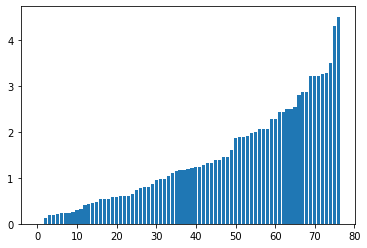

In [36]:
our_results["drivetimes"] =  (pd.to_datetime(our_results['Total Travel Time (h)'], format='%H:%M:%S').dt.hour + pd.to_datetime(our_results['Total Travel Time (h)'], format='%H:%M:%S').dt.minute/60).sort_values()
plt.bar(range(len(our_results["drivetimes"].to_list())),our_results["drivetimes"].sort_values().to_list())
print(len(our_results["drivetimes"].where(our_results["drivetimes"] < 1).dropna()))
print(len(our_results["drivetimes"].where(our_results["drivetimes"] > 1).dropna()))
print(our_results["drivetimes"].var())

In [38]:
our_results.where(our_results.drivetimes > 1).dropna().sort_values(by ="Total load (kg)" )

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h),drivetimes
60,68.730,01:14:35,193.0,9.620257,13.997173,55.291173,1.233333
63,65.704,01:07:21,372.0,9.455430,14.390950,58.533630,1.116667
16,86.910,01:27:28,908.0,12.908421,14.852630,59.618140,1.450000
49,78.462,01:23:04,1116.0,11.555241,14.727181,56.673997,1.383333
67,155.601,02:26:46,1316.0,24.228011,15.570601,63.611583,2.433333
50,70.763,01:10:06,1338.0,10.794041,15.253793,60.567475,1.166667
76,137.755,02:04:09,1500.0,22.183111,16.103307,66.575111,2.066667
70,84.047,01:20:20,1500.0,13.122272,15.613016,62.773693,1.333333
47,117.901,01:37:56,1721.0,20.252106,17.177213,72.233424,1.616667
71,223.398,03:13:53,1907.0,37.428553,16.754203,69.133740,3.216667


In [39]:
our_results.where(our_results.drivetimes < 1).dropna().sort_values(by ="Total load (kg)" )

,Total distance (km),Total Travel Time (h),Total load (kg),Fuel Consumption (L),Avg Fuel Conspumtion (L/100km),Avg Speed (km/h),drivetimes
21,0.016,00:00:33,89.0,0.004458,27.864144,1.745455,0.000000
30,5.239,00:14:27,440.0,1.020358,19.476202,21.753633,0.233333
59,24.128,00:33:41,865.0,3.438204,14.249851,42.979119,0.550000
32,59.455,00:59:45,1075.0,8.912812,14.990853,59.703766,0.983333
75,31.119,00:44:02,1305.0,4.525947,14.543999,42.402877,0.733333
61,10.894,00:24:48,1560.0,1.956066,17.955441,26.356452,0.400000
33,5.531,00:12:27,1676.0,0.978685,17.694537,26.655422,0.200000
74,36.738,00:35:13,1706.0,5.801382,15.791230,62.591955,0.583333
28,48.262,00:47:47,1755.0,7.364864,15.260171,60.601046,0.783333
29,39.850,00:36:33,1780.0,6.462351,16.216689,65.417237,0.600000


15
63
0.9748897149573905


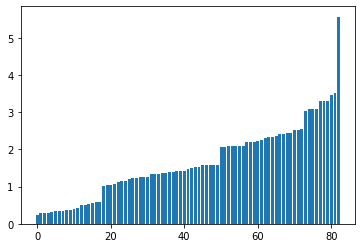

In [420]:
sigma_results_drive_times = pd.Series([round(int(x.total_seconds()/(60**2))+ ((x.total_seconds()/(60))%60)/100,2)  for x in pd.to_timedelta(sigma_results["Total Travel Time (h)"])]).sort_values() # (pd.to_datetime(sigma_results['Total Travel Time (h)'], format='%H:%M:%S').dt.hour + pd.to_datetime(sigma_results['Total Travel Time (h)'], format='%H:%M:%S').dt.hour + pd.to_datetime(sigma_results['Total Travel Time (h)'], format='%H:%M:%S').dt.minute/60).sort_values()
plt.bar(range(len(sigma_results_drive_times.to_list())),sigma_results_drive_times.to_list())#sigma_results_drive_times.plot(kind="bar")
print(len(our_results_drive_times.where(sigma_results_drive_times < 1).dropna()))
print(len(our_results_drive_times.where(sigma_results_drive_times > 1).dropna()))
print(sigma_results_drive_times.var())

33

In [9]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route[::-1]:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [339]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan","black"]
type_colors=["black","red","green"]
numerical_route = finished_sigma_routes
for routeNumber,route in enumerate(numerical_route):
    
    routes = []
    
    for stop in route:
        nodeType = 0
        if stop == route[0]:
            nodeType=2
        elif stop == route[-1]:
            nodeType=1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    
    
    
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [196]:
get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)

[[0, 26, 9, 10, 8, 33, 1, 15, 21],
 [23, 16, 17],
 [21, 12, 13, 11, 14],
 [24, 20, 2, 19, 3, 4, 17],
 [7, 6, 5, 17]]

In [197]:
finished_sigma_routes

[[33, 6, 5, 16, 3, 4, 18, 2, 19, 11, 17],
 [26, 12, 13, 14, 1, 15, 10, 9, 8, 17]]